# Global links

In [1]:
import sys
import os
import pandas as pd
import networkx as nx

# Get the parent directory of your current directory
parent_dir = os.path.dirname(os.getcwd())

# Add the parent directory to the sys.path
sys.path.append(parent_dir)

# Now you can import your module as usual
from SimulationRL import *
import SimulationRL

populationMap   = '../Population Map/gpw_v4_population_count_rev11_2020_15_min.tif'
outputPath      = './GlobalLinks/'
inputPath       = '../'
matching        = 'Greedy' # ['Markovian', 'Greedy']

No GPU available


In [2]:
inputParams = pd.read_csv(inputPath + "inputRL.csv")

locations = inputParams['Locations'].copy()
print('Nº of Gateways: ' + str(len(locations)))


env = simpy.Environment()
earth, _, _, _ = initialize(env, populationMap, inputPath + 'Gateways.csv', rKM, inputParams, movementTime, locations, outputPath, matching=matching)
G = earth.gateways[0].graph

Nº of Gateways: 18
Using Kepler constellation design
total divisions in x = 1440
 total divisions in y = 720
 total cells = 1036800
 window of operation (longitudes) = (0, 1440)
 window of operation (latitudes) = (0, 720)

Finding cells within coverage area of GT 18 of 18
Time taken to find cells that are within range of all GTs: 7.747256517410278 seconds
Time taken to add cell information to all GTs: 0.10262250900268555 seconds

Matching: Greedy
----------------------------------
Removing duplicated links...
0_1 east satellite duplicated: 6_19, 3_0
Keeping most horizontal link: 6_19
0_2 West satellite duplicated: 6_17, 6_18
Keeping most horizontal link: 6_18
0_2 east satellite duplicated: 1_2, 6_19
Keeping most horizontal link: 1_2
0_3 West satellite duplicated: 6_16, 6_17
Keeping most horizontal link: 6_17
0_7 east satellite duplicated: 1_6, 1_7
Keeping most horizontal link: 1_7
0_8 east satellite duplicated: 1_7, 1_8
Keeping most horizontal link: 1_8
0_9 east satellite duplicated: 1

d:\Federico\Q-Learning\SimulationRL.py:4360: RuntimeWarning: divide by zero encountered in double_scalars
  dataRate = 1/markovEdge.shannonRate,    # Inverse of dataRate


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                928       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 2,116
Trainable params: 2,116
Non-trainable params: 0
_________________________________________________________________
Saving hyperparams at: ./GlobalLinks/


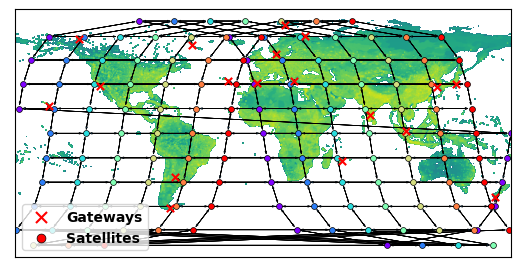

In [3]:
earth.plotMap(plotGT = True, plotSat = True, edges=True, save = True)

In [4]:
# Save edges into a txt
print(G)

# Print all edges
# print("\nEdges:")
with open(outputPath + 'edges.txt', 'w') as f:
    for edge in G.edges():
        f.write(str(edge)+'\n')

Graph with 158 nodes and 292 edges


In [5]:
def deleteDuplicatedLinks(satA, g, earth):
    '''
    Given a satellite, searches for its east and west neighbour. If the east or west link is duplicated,
    it will remove the link with a higher latitude difference, keeping the horizontal links
    '''

    def getMostHorizontal(currentSat, satA, satB):
        '''
        Chooses the dat with the closest latitude to currentSat
        '''
        return (satA, satB) if abs(satA.latitude-currentSat.latitude)<abs(satB.latitude-currentSat.latitude) else (satB, satA)

    linkedSats = {'U':None, 'D':None, 'R':None, 'L':None}
    for edge in list(g.edges(satA.ID)):
        if edge[1][0].isdigit():
            satB = findByID(earth, edge[1])
            dir = getDirection(satA, satB)

            if(dir == 3):                                         # Found Satellite at East
                if linkedSats['R'] is not None:
                    print(f"{satA.ID} east satellite duplicated: {linkedSats['R'].ID}, {satB.ID}")
                    most_horizontal, less_horizontal = getMostHorizontal(satA, linkedSats['R'], satB)
                    print(f'Keeping most horizontal link: {most_horizontal.ID}')
                    linkedSats['R']  = most_horizontal
                    # remove pair from G
                    G.remove_edge(satA.ID, less_horizontal.ID)
                else:
                    linkedSats['R']  = satB

            elif(dir == 4):                                         # Found Satellite at West
                if linkedSats['L'] is not None:
                    print(f"{satA.ID} West satellite duplicated: {linkedSats['L'].ID}, {satB.ID}")
                    most_horizontal, less_horizontal = getMostHorizontal(satA, linkedSats['L'], satB)
                    print(f'Keeping most horizontal link: {most_horizontal.ID}')
                    linkedSats['L']  = most_horizontal
                    # remove pair from G
                    G.remove_edge(satA.ID, less_horizontal.ID)
                else:
                    linkedSats['L']  = satB

# for plane in earth.LEO:
#     for sat in plane.sats:
#         deleteDuplicatedLinks(sat, G, earth)

# Check
# Pintar los enlaces y buscar cosas raras. Hay algunos en el norte que no han ido bien

# ToDo
# check if the links are actually bidirectional. Yo creo que sí por cómo se usan en getneighbors
# sospechosamente hay muchas trayectorias rectas que en lugar de 8 son 10 o 12. Raro que las random choices sean siempre en horizontal y no en vertical.
# Hay demasiadas, algo tiene que estar rayándose. Puede ser que sea la red neuronal o puede que los vecinos se estén dando mal a la red neuronal. O puede que el random no esté bien hecho. O puede que el random no pueda elegir esas opciones random porque el intra plane falle
# check if we have this with full exploitation. If so the problem is on the randomness asignment. If no then there is a problem with the neighbour showing to the DNN when we pass greenwich meridian.
# That means, maybe the satellites se dan al revés cuando se pasa de meridiano (Se intercambian el del este por el del oeste). Probar con bias si no a ver
# otra vez muchos stuck. hay un issue